<a href="https://colab.research.google.com/github/johncoder-30/Gan_pytorch/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(#1x28x28
            nn.Conv2d(channels_img, features_d, kernel_size=(4, 4), stride=(2, 2), padding=1),#64x14x14
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),#128x7x7
            self._block(features_d * 2, features_d * 4, 4, 2, 1),#256x4x4
            self._block(features_d * 4, features_d * 8, 4, 2, 1),#512x2x2
            nn.Conv2d(features_d * 8, 1, kernel_size=(4, 4), stride=(2, 2), padding=0),#1024x1x1
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding, bias=False),
            # Hout=[(Hin+2P-k)/s]+1
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(#100x1x1
            self._block(z_dim, features_g * 16, 4, 1, 0),#1024x2x2
            self._block(features_g * 16, features_g * 8, 4, 2, 1),#512x4x4
            self._block(features_g * 8, features_g * 4, 4, 2, 1),#256x7x7
            self._block(features_g * 4, features_g * 2, 4, 2, 1),#128x14x14
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),#1x28x28
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernal_size, stride, padding):
        return nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, kernal_size, stride, padding, bias=False),
                             nn.BatchNorm2d(out_channels),
                             nn.ReLU())

    def forward(self, x):
        return self.gen(x)


def initial_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

learning_rate = 2e-4
batch_size = 128
image_size = 64
channels_img = 1
z_dim = 100
num_epochs = 50
features_disc = 64
features_gen = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor(),
                                transforms.Normalize([0.5 for _ in range(channels_img)],
                                                     [0.5 for _ in range(channels_img)]),
                                ])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
gen = Generator(z_dim, channels_img, features_gen).to(device)
disc = Discriminator(channels_img, features_disc).to(device)
initial_weights(gen)
initial_weights(disc)
# print(gen)
# print(disc)
opt_gen = optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(128, z_dim, 1, 1).to(device)
# writer_real = SummaryWriter(f"logs/real")
# writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
disc.train()

In [ ]:
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
        disc_real = disc(real).reshape(-1)
        # print(real.shape)
        fake = gen(noise)
        # print(fake.shape)

        disc_fake = disc(fake).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_fake + loss_disc_real) / 2
        opt_disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()

        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
    if epoch % 10 == 0:
        print(f'loss generator={loss_gen.item()}')
        print(f'loss discriminator={loss_disc.item()}')
    

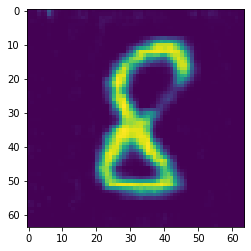

In [19]:
import matplotlib.pyplot as plt
z_dim=torch.randn((2,100,1,1)).to('cuda')
fake=gen(z_dim)
plt.imshow(fake[0][0].detach().cpu().numpy())
plt.show()

In [20]:
torch.save(disc.state_dict(),'/content/disc.pth')
torch.save(gen.state_dict(),'/content/gen.pth')


In [22]:
# from google.colab import drive
# drive.mount('/content/gdrive')

torch.save({gen:gen.state_dict(),disc:disc.state_dict()},'/content/gdrive/My Drive/pytorch_models/dcgan.pth')